In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy.stats import shapiro
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.metrics import ConfusionMatrixDisplay


In [246]:
df = pd.read_csv(r"C:\Users\maxim\Downloads\billets.csv", sep=";")
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [247]:
df.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [248]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [249]:
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [250]:
df_genuine = df[df['is_genuine'] == True]
df_genuine.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      29
margin_up        0
length           0
dtype: int64

In [251]:
df.duplicated().sum()

0

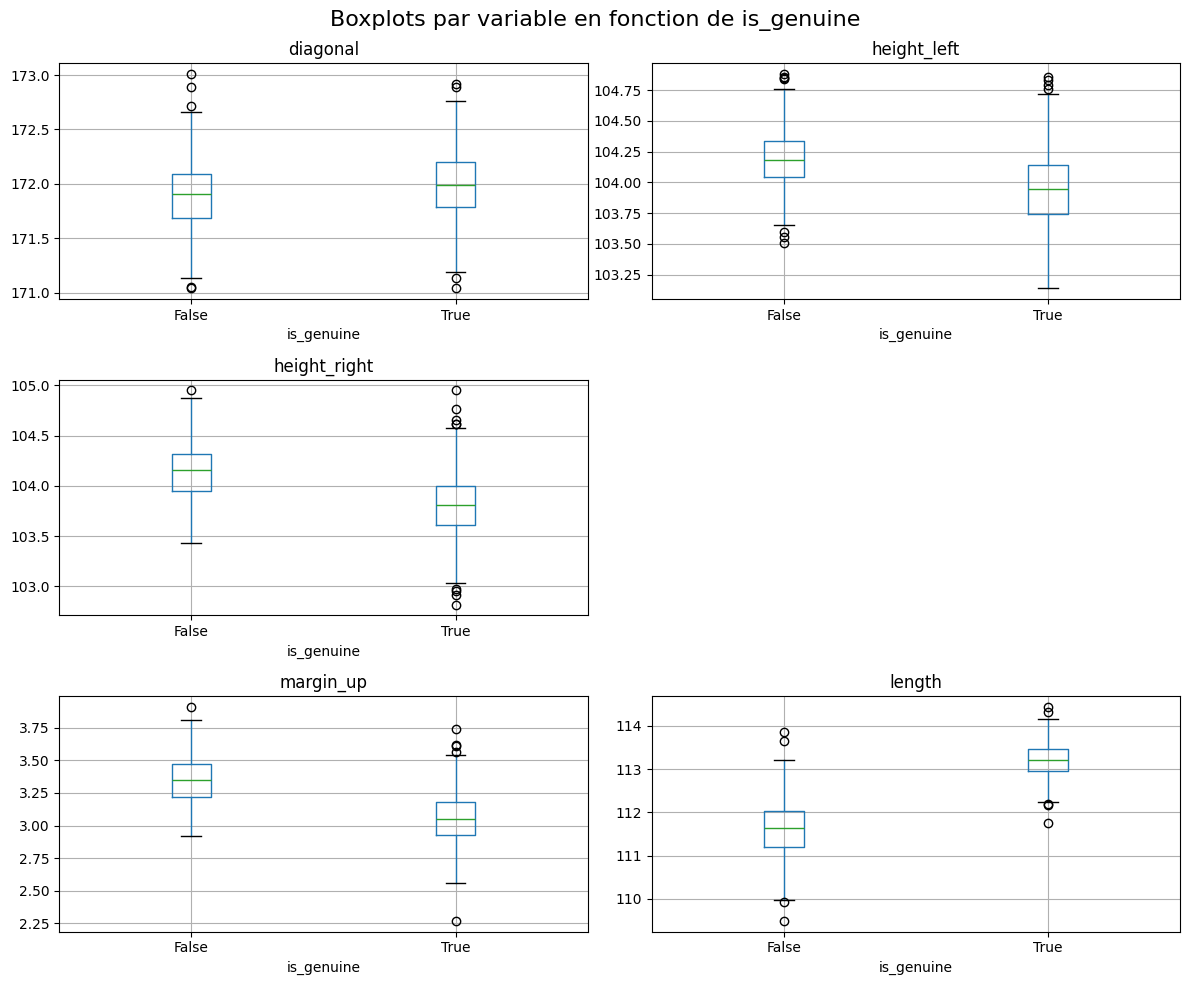

In [252]:
fig, axes = plt.subplots(3,2, figsize=(12, 10))

for i, el in enumerate(list(df.columns.values)[1:]):  
    df.boxplot(el, by="is_genuine", ax=axes.flatten()[i])

fig.delaxes(axes[1,1])
fig.suptitle("Boxplots par variable en fonction de is_genuine", fontsize=16)
plt.tight_layout() 
plt.show()

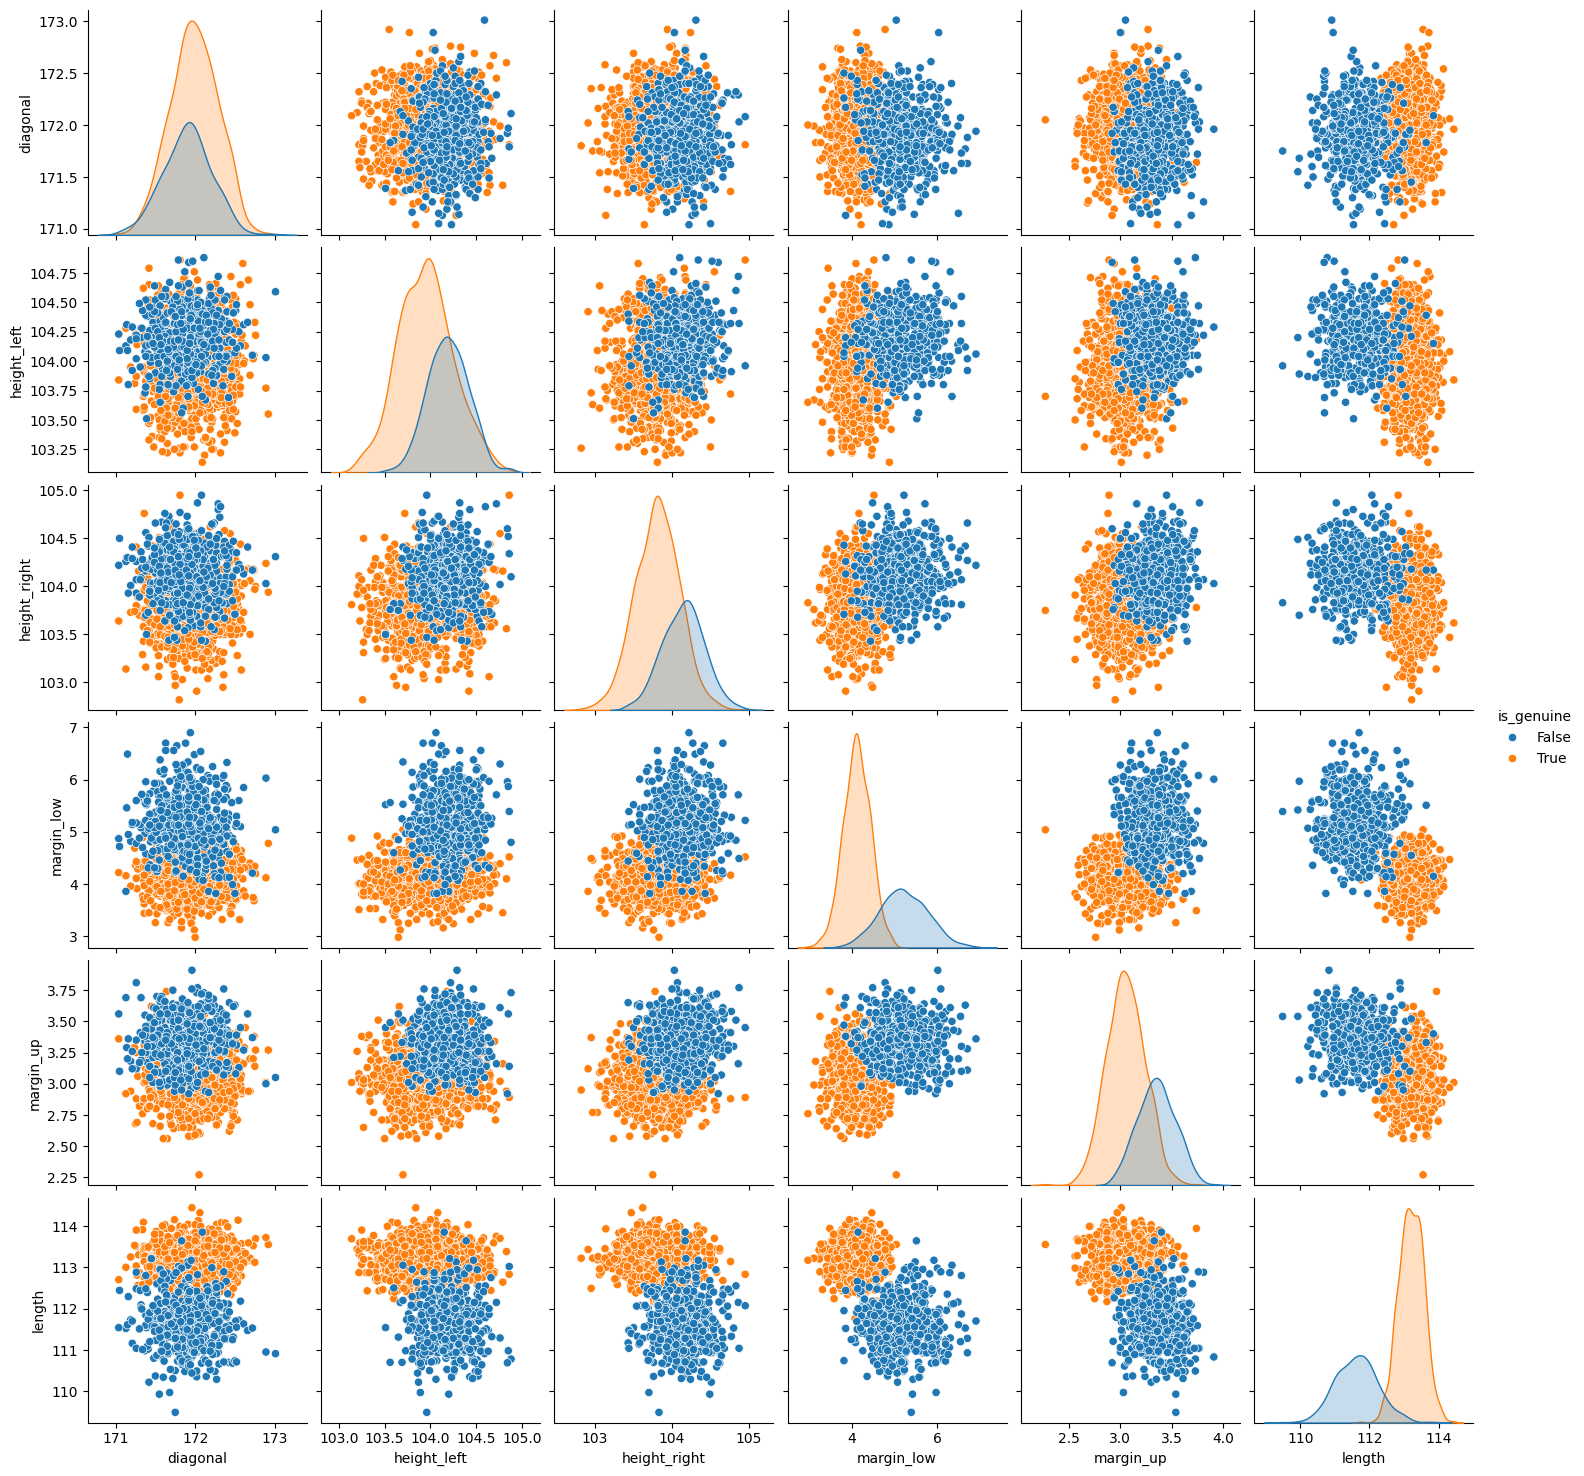

In [253]:
sns.pairplot(df, hue='is_genuine')

Les courbes de distribution de margin_low et length selon l'authenticité du billet sont bien distinctes: on peut en déduire que les vrais billets auront une longueur plus grande que les faux, et qu'ils auront une marge basse plus faible que les faux. On note également que le nuage de point entre length et margin low semblent bien distincts.

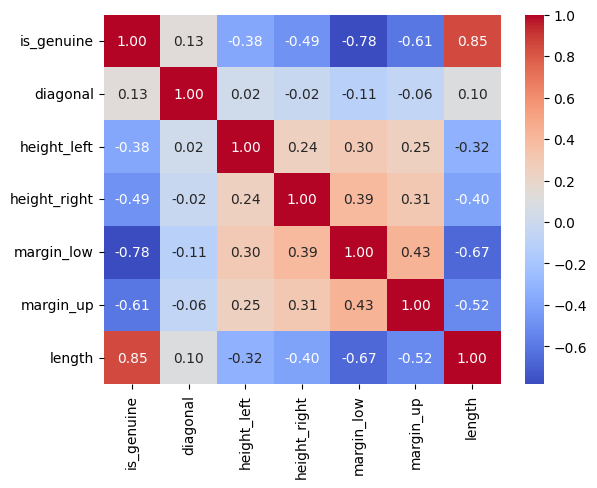

In [254]:
corr = df.corr() 
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

On note des coefficients de corrélation élevés entre les variables length & is_genuine (0.85), margin_low & is_genuine (-0.78) et margin_low & length (-0.67).

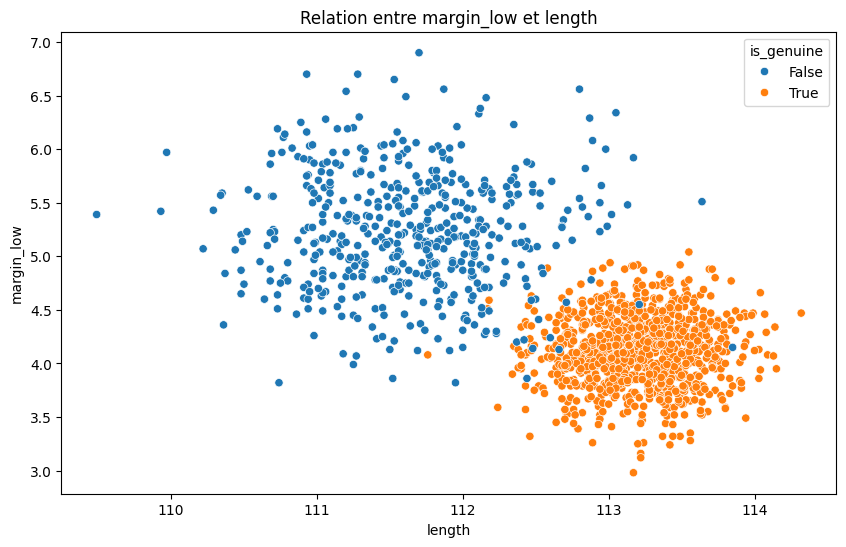

In [255]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='length', y='margin_low', hue='is_genuine')
plt.title('Relation entre margin_low et length')
plt.show()

In [256]:
from sklearn.linear_model import LinearRegression
df_full = df.copy().dropna()
X = df_full[['diagonal', 'height_left', 'height_right', 'margin_up', 'length', 'is_genuine']]
reg = LinearRegression()
reg.fit(X, df_full['margin_low'])
print(f"R^2 : {np.round(reg.score(X, df_full['margin_low']), 3)}")
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': reg.coef_})
print(coefficients)


R^2 : 0.617
       Variable  Coefficient
0      diagonal    -0.013016
1   height_left     0.028291
2  height_right     0.026750
3     margin_up    -0.212844
4        length    -0.003883
5    is_genuine    -1.140597


Ce modèle a un score modéré : il explique 61.7% de la variance de margin_low. La variable is_genuine est celle qui a le plus d'impact avec un coefficient de -1.14. on peut essayer de simplifier le modèle en utilisant uniquement la variable length.

In [257]:
X_simple = df_full[['margin_low']]
reg_simple = LinearRegression()
reg_simple.fit(X_simple, df_full['is_genuine'])
r2_simple = reg_simple.score(X_simple, df_full['is_genuine'])
print(f"R^2 avec uniquement 'length' : {np.round(r2_simple, 3)}")
print(f"Coefficient de 'length' : {reg_simple.coef_[0]:.3f}")

R^2 avec uniquement 'length' : 0.613
Coefficient de 'length' : -0.557


La variable is_genuine explique 61.3% de la variance de margin_low, soit un score très proche de la régression du modèle qui utilise toutes les variables, on peut donc priviliégier cette approche plus robuste pour remplacer les valeurs margin_low manquantes.

In [258]:
# Autre approche en utilsant length et is_genuine car on a des coef de correlation élevés 
import statsmodels.formula.api as smf

df_full['is_genuine'] = df_full['is_genuine'].astype(int)
model = smf.ols('margin_low ~ length + is_genuine + diagonal  +height_left + height_right + margin_up', data=df_full).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          4.75e-299
Time:                        12:24:32   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

In [259]:
#model_no_is_genuine = smf.ols('margin_low ~ length', data=df_full).fit()
#print(model_no_is_genuine.summary())

In [260]:
model = smf.ols('margin_low ~  is_genuine + diagonal + height_left + height_right + margin_up', data=df_full).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          2.12e-300
Time:                        12:24:32   Log-Likelihood:                -774.15
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.4247      7.873      0.308   

In [261]:
model = smf.ols('margin_low ~  is_genuine + height_left + height_right + margin_up', data=df_full).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          8.76e-302
Time:                        12:24:32   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3902      5.476      0.071   

In [262]:
model = smf.ols('margin_low ~  is_genuine + height_left + margin_up', data=df_full).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          3.63e-303
Time:                        12:24:32   Log-Likelihood:                -774.45
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.9104      4.035      0.721      

In [263]:
model = smf.ols('margin_low ~   is_genuine + margin_up', data=df_full).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Sat, 15 Mar 2025   Prob (F-statistic):          1.24e-304
Time:                        12:24:32   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

# Colinéarité

In [264]:
variables = model.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007741]

Ces valeurs sont inférieures à 5, ce qui indique une faible multicolinéarité.

# Homoscédasticité

In [265]:
_, pval, __, f_pval = sms.het_breuschpagan(model.resid, model.model.exog)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.2033559115862154e-36


# Normalité des résidus

In [266]:
shapiro(model.resid)

ShapiroResult(statistic=0.9936252795074536, pvalue=6.2144467504175505e-06)

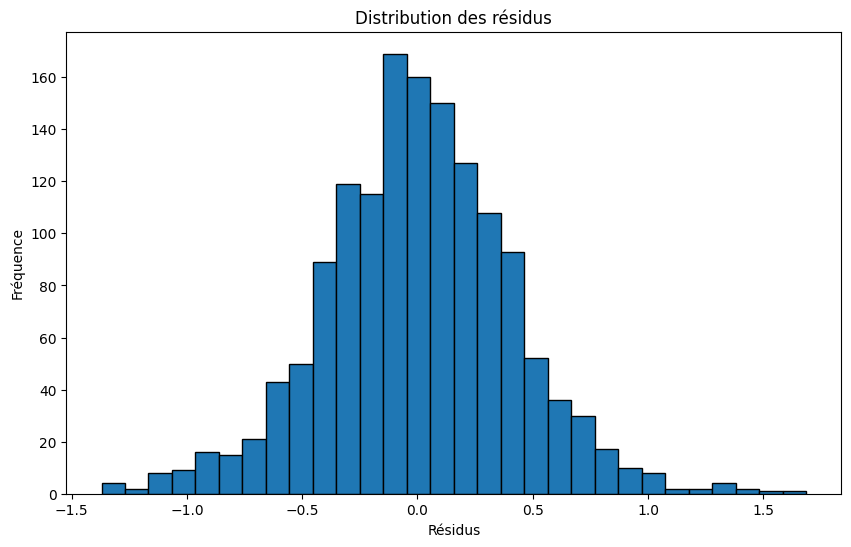

In [267]:
plt.figure(figsize=(10, 6))
plt.hist(model.resid, bins=30, edgecolor='black')
plt.title("Distribution des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()


La pvalue inférieure à 0.05 on rejette l'hypothèse nulle selon laquelle les résidus sont normalement distribués. L'histogramme montre une distribution relativement symétrique mais e test de shapiro wilk indique qu'il peut y avoir des écarts par rapport à la normalité.

Malgré les résultats des tests, l'approche du remplacement des valeurs manquantes reste tout de même plus pertinent que d'utiliser la moyenne des valeurs.

# Remplacer les valeurs manquantes

In [268]:
df_new = df.copy()
model = smf.ols('margin_low ~ is_genuine + margin_up', data=df_full).fit()
missing_rows = df_new.loc[df_new['margin_low'].isna()].index
X = df_new.loc[missing_rows, ['is_genuine', 'margin_up']].copy()
X.loc[:, 'is_genuine'] = X['is_genuine'].astype(float)
X.loc[:, 'margin_up'] = X['margin_up'].astype(float)
X = sm.add_constant(X)
prediction = model.get_prediction(X)
predicted_values = prediction.predicted_mean
df_new.loc[missing_rows, 'margin_low'] = predicted_values

print(f"Nombre de lignes dans df_new : {len(df_new)}")
print(df_new['margin_low'].isnull().sum())

Nombre de lignes dans df_new : 1500
0


C:\Users\maxim\AppData\Local\Temp\ipykernel_10776\285851624.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, 'is_genuine'] = X['is_genuine'].astype(float)


In [269]:
len(df_new)

1500

In [270]:
len(df)

1500

# Regression logistique

In [271]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

X = df_new.drop('is_genuine', axis=1)
y = df_new['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=155)

logr = LogisticRegression()
logr.fit(X_train, y_train)
y_pred = logr.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 89   2]
 [  3 206]]


              precision    recall  f1-score   support

       False       0.97      0.98      0.97        91
        True       0.99      0.99      0.99       209

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



Presque tous les billets prédits comme faux le sont (F1 score de 99%).

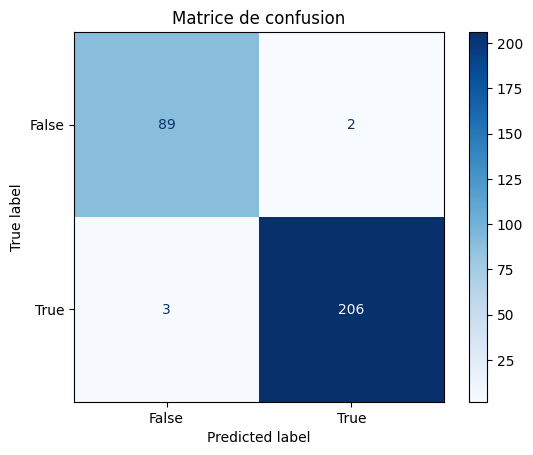

In [272]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logr.classes_)
disp.plot(cmap="Blues", values_format="d")  
plt.title("Matrice de confusion")
plt.show()

In [273]:
for feature, coef in zip(X.columns, logr.coef_[0]):
    print(f"{feature}: {coef}")


diagonal: -0.06395833371437512
height_left: -1.5938160253926814
height_right: -2.266379353158357
margin_low: -3.637761469092007
margin_up: -2.9719832959570733
length: 3.9009894676500876


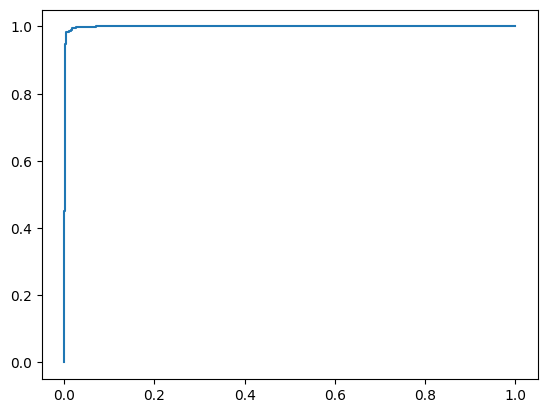

In [274]:
from sklearn.metrics import roc_curve
y_hat_proba = logr.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_hat_proba)
plt.plot(fpr, tpr)

La courbe ROC monte rapidement à gauche indiquant une quasi parfaite capacité de discrimination du modèle.

In [275]:
# Validation croisée
lr_scores = cross_val_score(logr, X, y, cv=5)
print("Régression logistique - Scores:", lr_scores.mean(), "±", lr_scores.std())

Régression logistique - Scores: 0.99 ± 0.004216370213557831


# K means

In [276]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

Validation du nombre de clusters pour KMeans via la méthode de la silhouette pour confirmer le nombre de clusters :


n_clusters: 2
silhouette_score: 0.3479965235676205

n_clusters: 3
silhouette_score: 0.2630487911260662

n_clusters: 4
silhouette_score: 0.16069847958245248

n_clusters: 5
silhouette_score: 0.15596095228212847

n_clusters: 6
silhouette_score: 0.15395473527548528

n_clusters: 7
silhouette_score: 0.14850693598956458


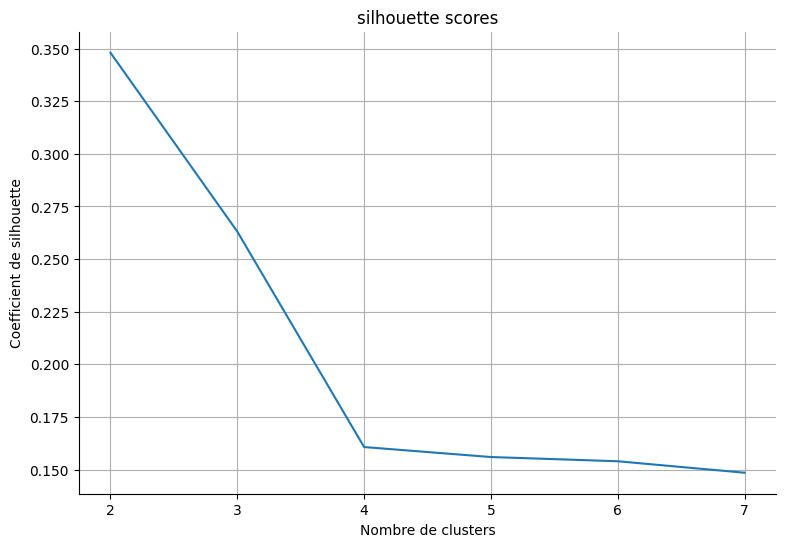

In [277]:
df_kmeans = df_new.copy()
X = df_kmeans.drop('is_genuine', axis=1)
y = df_kmeans['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
silhouette_scores = []
for n_clusters in range(2, 8):
    print(f"\nn_clusters: {n_clusters}")
    k_means = KMeans(init="k-means++", n_clusters=n_clusters, random_state=808, n_init='auto')
    k_means.fit(X_train_scaled)  

    train_labels = k_means.predict(X_train_scaled) 
    silhouette_avg = silhouette_score(X_train_scaled, train_labels)
    print(f"silhouette_score: {silhouette_avg}")
    silhouette_scores.append(silhouette_avg)

fig = plt.figure(figsize=(9, 6))

ax = fig.add_subplot(1, 1, 1)
plt.plot(range(2, 8), silhouette_scores)
ax.set_title('silhouette scores')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coefficient de silhouette')
plt.grid()
plt.show()


Le calcul du score de silhouette permet de confirmer que l'on appliquera KMeans avec 2 clusters.

In [278]:
model = KMeans(n_clusters=2, n_init='auto')
model.fit(X_train_scaled)

KMeans(n_clusters=2)

Le cluster 0 correspond à 'is_genuine'


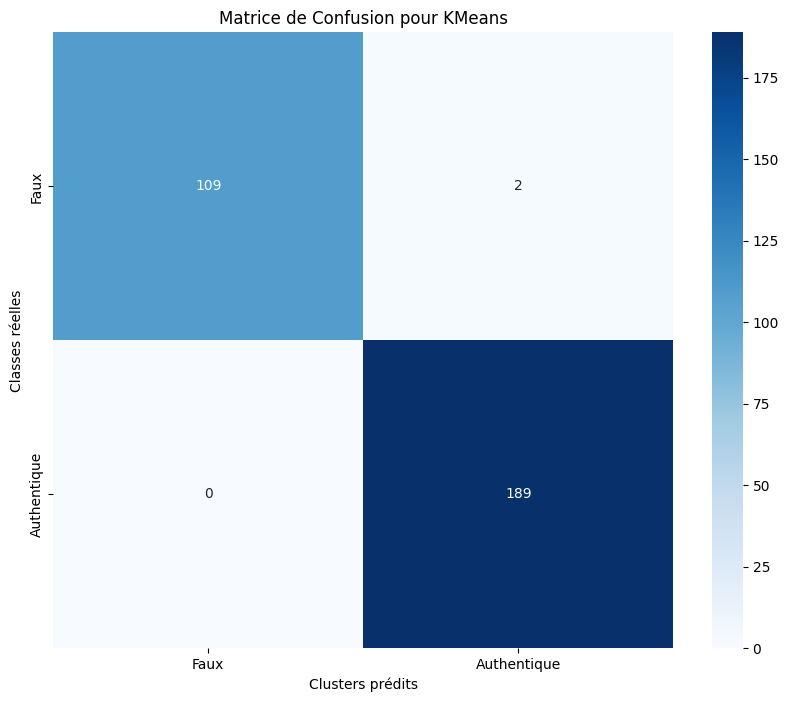

In [279]:
test_labels = model.predict(X_test_scaled)

# Déterminer à quelle classe correspond "is_genuine"
genuine_mean = X_train_scaled[y_train == 1].mean(axis=0)
not_genuine_mean = X_train_scaled[y_train == 0].mean(axis=0)

distances_genuine = np.linalg.norm(model.cluster_centers_ - genuine_mean, axis=1)
distances_not_genuine = np.linalg.norm(model.cluster_centers_ - not_genuine_mean, axis=1)
is_genuine_cluster = np.argmin(distances_genuine)
print(f"Le cluster {is_genuine_cluster} correspond à 'is_genuine'")
remapped_labels = np.where(test_labels == is_genuine_cluster, 1, 0)


cm = confusion_matrix(y_test, remapped_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Faux', 'Authentique'], 
            yticklabels=['Faux', 'Authentique'])
plt.title('Matrice de Confusion pour KMeans')
plt.xlabel('Clusters prédits')
plt.ylabel('Classes réelles')
plt.show()

In [280]:
accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


Avec ce modèle, nous avons une précision de 99% avec 2 faux positifs.

# KNN

In [281]:
from sklearn.neighbors import KNeighborsClassifier

In [282]:
# Préparation des données
df_knn = df_new.copy()
X = df_knn.drop('is_genuine', axis=1)
y = df_knn['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

K=1, Taux d'erreur=0.0200
K=2, Taux d'erreur=0.0100
K=3, Taux d'erreur=0.0133
K=4, Taux d'erreur=0.0133
K=5, Taux d'erreur=0.0167
K=6, Taux d'erreur=0.0067
K=7, Taux d'erreur=0.0167
K=8, Taux d'erreur=0.0133
K=9, Taux d'erreur=0.0133
K=10, Taux d'erreur=0.0133
K=11, Taux d'erreur=0.0133
K=12, Taux d'erreur=0.0133
K=13, Taux d'erreur=0.0133
K=14, Taux d'erreur=0.0100
K=15, Taux d'erreur=0.0133
K=16, Taux d'erreur=0.0133
K=17, Taux d'erreur=0.0133
K=18, Taux d'erreur=0.0100
K=19, Taux d'erreur=0.0133
K=20, Taux d'erreur=0.0133
K=21, Taux d'erreur=0.0133
K=22, Taux d'erreur=0.0133
K=23, Taux d'erreur=0.0133
K=24, Taux d'erreur=0.0133
K=25, Taux d'erreur=0.0133
K=26, Taux d'erreur=0.0133
K=27, Taux d'erreur=0.0133
K=28, Taux d'erreur=0.0133
K=29, Taux d'erreur=0.0133
K=30, Taux d'erreur=0.0100
K=31, Taux d'erreur=0.0133
K=32, Taux d'erreur=0.0100
K=33, Taux d'erreur=0.0133
K=34, Taux d'erreur=0.0133
K=35, Taux d'erreur=0.0133
K=36, Taux d'erreur=0.0133
K=37, Taux d'erreur=0.0133
K=38, Taux

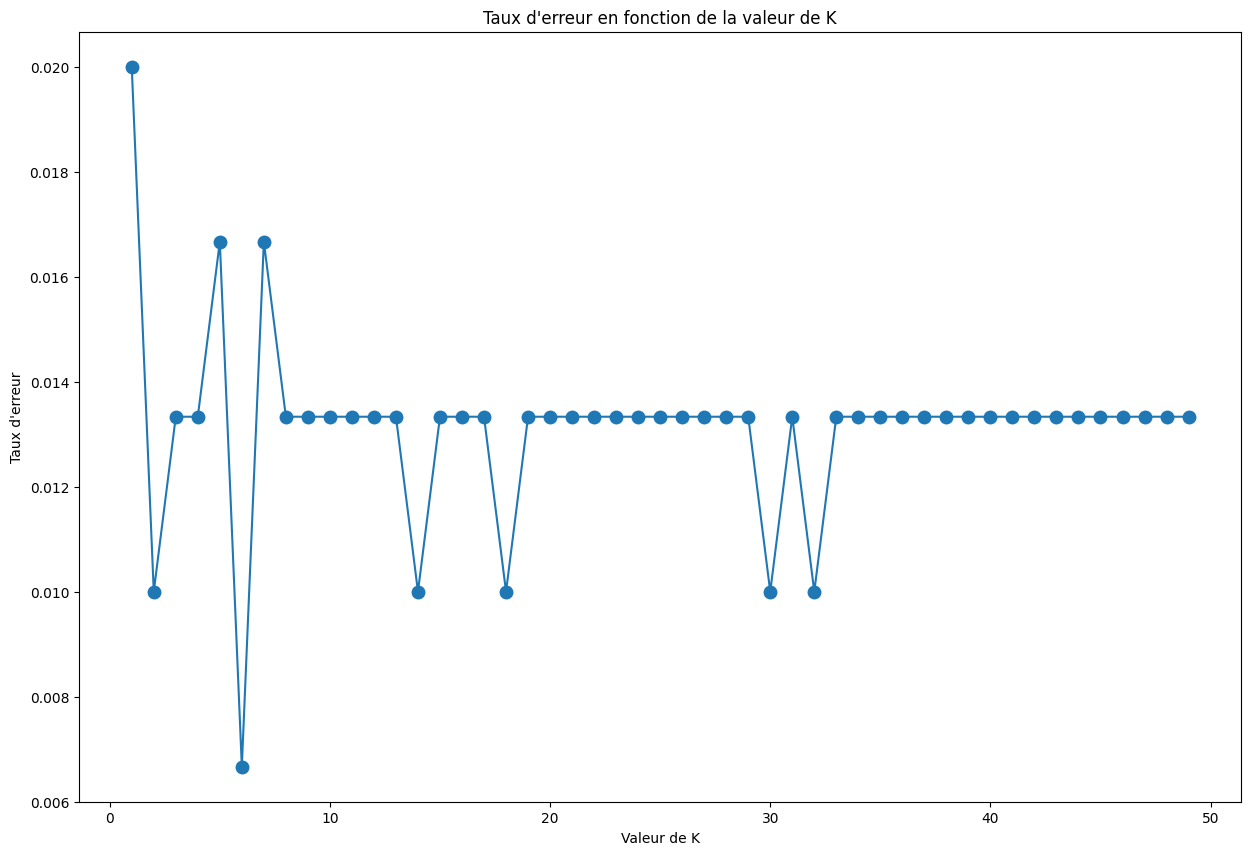

In [283]:
# Trouver k
error_rate = []

for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
for k, error in enumerate(error_rate):
    print(f"K={k+1}, Taux d'erreur={error:.4f}")

plt.figure(figsize=(15, 10))
plt.plot(range(1, 50), error_rate, marker='o', markersize=9)
plt.title('Taux d\'erreur en fonction de la valeur de K')
plt.xlabel('Valeur de K')
plt.ylabel('Taux d\'erreur')
plt.show()

Le taux d'erreur pour k=3 est 0.00, on va donc utiliser cette valeur de k pour le modèle KNN.

In [284]:

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Matrice de confusion:\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification:\n", classification_report(y_test, y_pred))

Matrice de confusion:
 [[106   4]
 [  0 190]]

Rapport de classification:
               precision    recall  f1-score   support

       False       1.00      0.96      0.98       110
        True       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



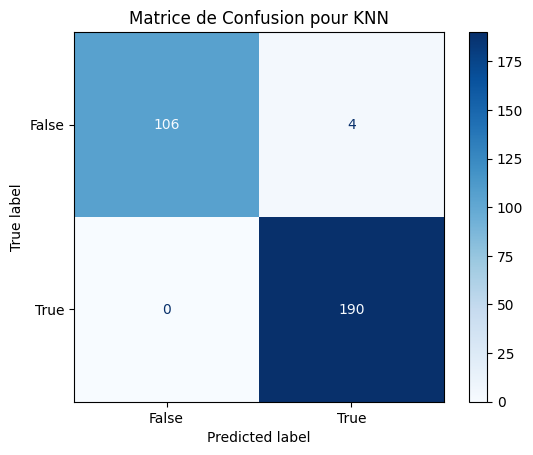

In [285]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de Confusion pour KNN')
plt.show()

In [286]:
# Validation croisée
knn_scores = cross_val_score(knn, X, y, cv=5)
print("KNN - Scores:", knn_scores.mean(), "±", knn_scores.std())

KNN - Scores: 0.9906666666666666 ± 0.003887301263230195


# Random Forest

In [287]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [288]:
df_rf = df_new.copy()
X = df_rf.drop('is_genuine', axis=1)
y = df_rf['is_genuine']

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9966666666666667

Confusion Matrix:
[[110   1]
 [  0 189]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       111
        True       0.99      1.00      1.00       189

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



Encore une fois un très bon modèle avec une accuracy de 98.98%, avec 1 faux négatif et 2 faux positifs.

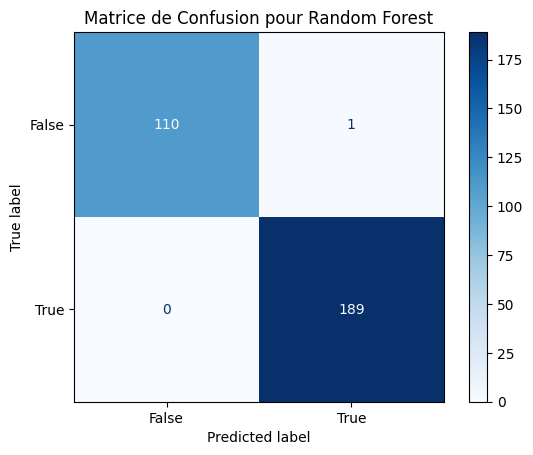

In [290]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion pour Random Forest")
plt.show()

In [291]:
# Validation croisée
rf_scores = cross_val_score(rf_model, X, y, cv=5)
print("Random Forest - Scores:", rf_scores.mean(), "±", rf_scores.std())

Random Forest - Scores: 0.9906666666666666 ± 0.0038873012632301947


# Choix du modèle

In [292]:
print("Régression logistique - Scores:", lr_scores.mean(), "±", lr_scores.std())
print("KNN - Scores:", knn_scores.mean(), "±", knn_scores.std())
print("Random Forest - Scores:", rf_scores.mean(), "±", rf_scores.std())

Régression logistique - Scores: 0.99 ± 0.004216370213557831
KNN - Scores: 0.9906666666666666 ± 0.003887301263230195
Random Forest - Scores: 0.9906666666666666 ± 0.0038873012632301947


Le modèle random forest a ici le meilleur score même si les 3 résultats sont excellents. Random forest est cependant moins sujet au surapprentissage car il combine les prédictions de plusieurs arbres, ce sera donc le modèle retenu pour l'analyse des futurs billets.

In [293]:
joblib.dump(rf_model, 'random_forest_model.pkl')
feature_names = X.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")

['feature_names.pkl']

# Modèle supplémentaire

On peut tester le modèle XGBoost qui gère efficacement les données déséquilibrées (on a 500 faux billets et 1000 vrais) et évite le surajustement. 

In [294]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
df_xgb = df_new.copy()
X = df_xgb.drop('is_genuine', axis=1)
y = df_xgb['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 59)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=59)
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score de validation croisée:", grid_search.best_score_)

Meilleurs paramètres: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 1.0}
Meilleur score de validation croisée: 0.99


In [295]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy sur l'ensemble de test: {accuracy}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Accuracy sur l'ensemble de test: 0.9966666666666667

Rapport de classification:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99        94
        True       1.00      1.00      1.00       206

    accuracy                           1.00       300
   macro avg       0.99      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



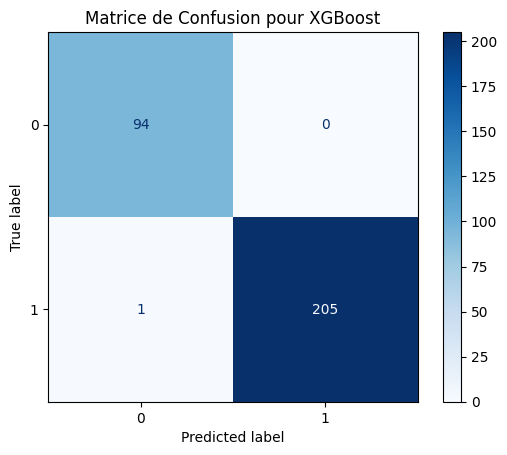

In [296]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion pour XGBoost")
plt.show()